In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(767660, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


In [50]:
data = dataset[dataset.id == 1][dataset.trial == 3]
len(data.index) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2635

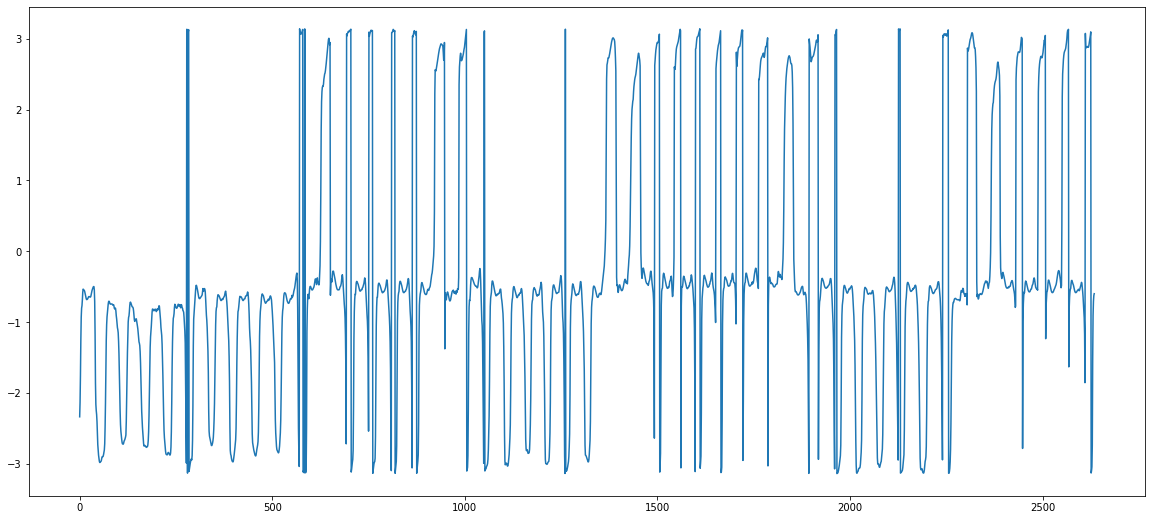

In [51]:
plt.figure(figsize=(20, 9))
plt.plot(range(len(data.index)), data['attitude.roll'])